# Advanced Isolation Forest Tuning

This notebook refines a previously trained Isolation Forest model to improve attack detection (recall) **without sacrificing benign traffic precision or recall**. It performs advanced threshold tuning and parameter refinement, carefully controlling false positives and avoiding overfitting.

Key Objectives:
- Load the existing model, scaler, and full evaluation dataset.
- Search thresholds that improve attack recall while preserving benign performance.
- Compare outcomes to the previous best to ensure only beneficial changes are saved.
- Visualize precision-recall tradeoffs and detailed confusion matrix metrics.


## 1. Setup and Data Loading

This section loads:
- The previously saved Isolation Forest model and scaler
- The threshold and tuning summary (CSV)
- The full evaluation dataset (features and labels)

Data is immediately scaled for evaluation.


In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from pathlib import Path

from joblib import Parallel, delayed

In [2]:
# Load previously tuned model and its scaler
model_path = Path("../../models/2_first_tuning/iforest_tuned.joblib")
scaler_path = Path("../../models/1_first_model/scaler.joblib")

best_model = joblib.load(model_path)
scaler = joblib.load(scaler_path)

# Load clean dataset and prepare features
data = pd.read_csv("../../data/cleaned_cic.csv")
data.columns = data.columns.str.strip().str.lower()
X = data.drop("attack", axis=1)
y = data["attack"]
X_scaled = scaler.transform(X)

# Get anomaly scores from decision_function
scores = best_model.decision_function(X_scaled)


## 2. Multi-Objective Threshold Evaluation

This section sweeps through different threshold values to find the optimal threshold that balances recall for attack detection, benign traffic precision, and minimizes false positive rate. 

Then, it visualizes how recall (for both benign and attack), false positive rate, and the custom score vary across different threshold values. It helps select a tradeoff point with the best balance.

In [3]:
# Custom multi-objective scoring function
def eval_threshold(t):
    preds = np.where(scores < t, 1, 0)
    p = precision_score(y, preds, zero_division=0)
    r = recall_score(y, preds, zero_division=0)

    # Discard trivial models
    if r > 0.98 and p < 0.2:
        return None
    if p > 0.98 and r < 0.2:
        return None

    cm = confusion_matrix(y, preds)
    tn, fp = cm[0][0], cm[0][1]
    fn, tp = cm[1][0], cm[1][1]

    recall_benign = tn / (tn + fp) if (tn + fp) else 0
    recall_attack = tp / (tp + fn) if (tp + fn) else 0
    fpr = fp / (fp + tn) if (fp + tn) else 0

    score = 0.4 * recall_attack + 0.4 * recall_benign - 0.2 * fpr
    return (t, p, recall_attack, recall_benign, fpr, score)

# Generate threshold sweep
fine_thresholds = np.linspace(-0.1, 0.2, 200)
parallel_results = Parallel(n_jobs=-1)(delayed(eval_threshold)(t) for t in fine_thresholds)
filtered_results = [r for r in parallel_results if r is not None]

# Create DataFrame
results_df = pd.DataFrame(filtered_results, columns=[
    "Threshold", "Precision", "Recall_Attack", "Recall_Benign", "FPR", "Score"
])

# Select best threshold based on multi-objective score
best_row = results_df.loc[results_df["Score"].idxmax()]
best_threshold = best_row["Threshold"]

print("Best Threshold Based on Multi-Objective Score:")
print(best_row)


Best Threshold Based on Multi-Objective Score:
Threshold        0.050754
Precision        0.733397
Recall_Attack    0.432294
Recall_Benign    0.961493
FPR              0.038507
Score            0.549814
Name: 100, dtype: float64


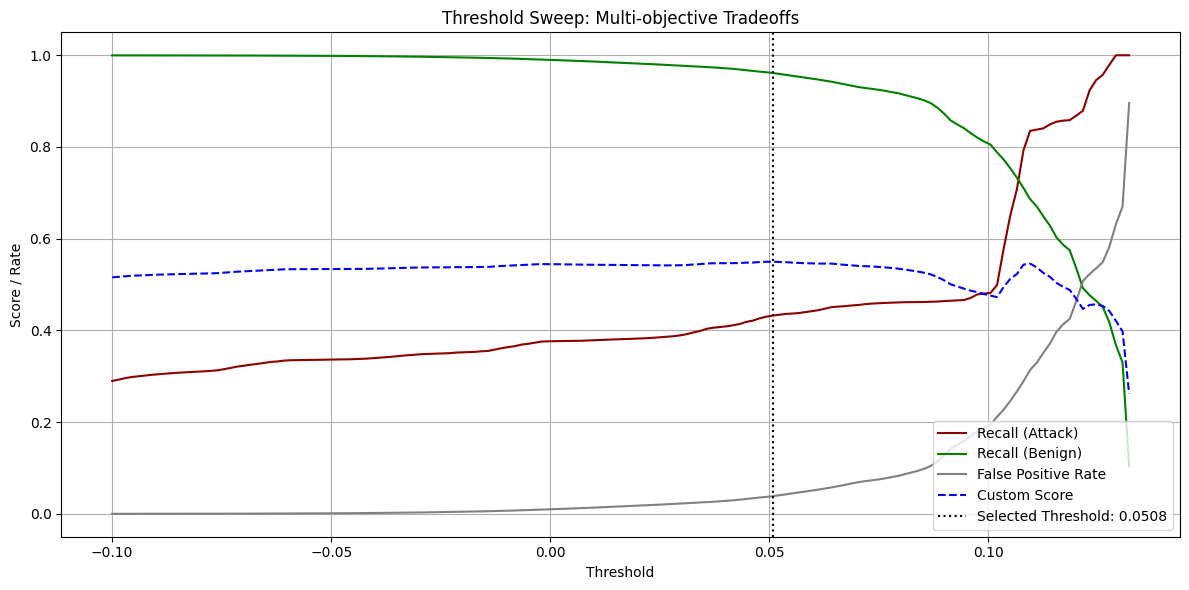

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(results_df["Threshold"], results_df["Recall_Attack"], label="Recall (Attack)", color="darkred")
plt.plot(results_df["Threshold"], results_df["Recall_Benign"], label="Recall (Benign)", color="green")
plt.plot(results_df["Threshold"], results_df["FPR"], label="False Positive Rate", color="gray")
plt.plot(results_df["Threshold"], results_df["Score"], label="Custom Score", color="blue", linestyle="--")
plt.axvline(x=best_threshold, color="black", linestyle="dotted", label=f"Selected Threshold: {best_threshold:.4f}")
plt.xlabel("Threshold")
plt.ylabel("Score / Rate")
plt.title("Threshold Sweep: Multi-objective Tradeoffs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 3. Final Evaluation with Best Threshold

Applies the selected threshold to generate final predictions, prints the confusion matrix and classification report, and summarizes counts of true/false positives and negatives.

In [5]:
# Apply best threshold
final_preds = np.where(scores < best_threshold, 1, 0)
conf_mat = confusion_matrix(y, final_preds)

# Show results
print("Confusion Matrix:")
print(conf_mat)

print("\nClassification Report:")
print(classification_report(y, final_preds, target_names=["Benign", "Attack"]))

# Breakdown
tn, fp = conf_mat[0][0], conf_mat[0][1]
fn, tp = conf_mat[1][0], conf_mat[1][1]

print(f"\nTrue Negatives (Benign correct):      {tn:,}")
print(f"False Positives (Benign flagged):     {fp:,}")
print(f"False Negatives (Missed attacks):     {fn:,}")
print(f"True Positives (Attacks detected):    {tp:,}")


Confusion Matrix:
[[2183859   87461]
 [ 315960  240596]]

Classification Report:
              precision    recall  f1-score   support

      Benign       0.87      0.96      0.92   2271320
      Attack       0.73      0.43      0.54    556556

    accuracy                           0.86   2827876
   macro avg       0.80      0.70      0.73   2827876
weighted avg       0.85      0.86      0.84   2827876


True Negatives (Benign correct):      2,183,859
False Positives (Benign flagged):     87,461
False Negatives (Missed attacks):     315,960
True Positives (Attacks detected):    240,596


## 4. Aggressive Threshold Optimization

This section defines and applies an alternative scoring strategy designed to increase detection of attacks (attack recall), while maintaining acceptable levels of benign recall and false positive rate. A custom scoring function is used to sweep a narrow range of thresholds in parallel. The best-performing threshold is selected based on this balanced objective.

In [6]:
# Balanced scoring: prioritize attack recall but reduce false positives
def aggressive_threshold_eval(t):
    preds = np.where(scores < t, 1, 0)

    # Basic metrics
    p = precision_score(y, preds, zero_division=0)
    r = recall_score(y, preds, zero_division=0)
    
    cm = confusion_matrix(y, preds)
    tn, fp = cm[0][0], cm[0][1]
    fn, tp = cm[1][0], cm[1][1]
    
    recall_benign = tn / (tn + fp) if (tn + fp) else 0
    recall_attack = tp / (tp + fn) if (tp + fn) else 0
    fpr = fp / (fp + tn) if (fp + tn) else 0

    # Balanced scoring formula
    score = 0.5 * recall_attack + 0.35 * recall_benign - 0.15 * fpr
    
    return (t, p, recall_attack, recall_benign, fpr, score)


In [7]:
aggressive_thresholds = np.linspace(0.0, 0.2, 250)  # narrower, safer range

aggressive_results = Parallel(n_jobs=-1)(
    delayed(aggressive_threshold_eval)(t) for t in aggressive_thresholds
)

aggressive_results = [r for r in aggressive_results if r is not None]

# Convert to DataFrame
aggressive_df = pd.DataFrame(aggressive_results, columns=[
    "Threshold", "Precision", "Recall_Attack", "Recall_Benign", "FPR", "Score"
])

# Select best threshold
best_aggressive = aggressive_df.loc[aggressive_df["Score"].idxmax()]
aggressive_threshold = best_aggressive["Threshold"]

print("Selected Aggressive Threshold:")
print(best_aggressive)


Selected Aggressive Threshold:
Threshold        0.108434
Precision        0.407391
Recall_Attack    0.824668
Recall_Benign    0.706055
FPR              0.293945
Score            0.615361
Name: 135, dtype: float64


## 5. Predict, Display and Save

This section applies the selected aggressive threshold to generate final predictions. It prints detailed metrics (recall, precision, F1, accuracy, confusion matrix) and saves both the tuned model and threshold configuration to disk for future use

In [8]:
# Predict using best aggressive threshold
aggressive_preds = np.where(scores < aggressive_threshold, 1, 0)

# Confusion matrix
cm = confusion_matrix(y, aggressive_preds)
tn, fp = cm[0][0], cm[0][1]
fn, tp = cm[1][0], cm[1][1]

# Metrics
precision = precision_score(y, aggressive_preds, zero_division=0)
recall = recall_score(y, aggressive_preds, zero_division=0)
f1 = f1_score(y, aggressive_preds, zero_division=0)
accuracy = accuracy_score(y, aggressive_preds)
recall_benign = tn / (tn + fp) if (tn + fp) else 0
fpr = fp / (fp + tn) if (fp + tn) else 0

# Display
print("=== Confusion Matrix ===")
print(cm)

print("\n=== Classification Report ===")
print(classification_report(y, aggressive_preds, target_names=["Benign", "Attack"]))

print("\n=== Detailed Statistics ===")
print(f"True Negatives (Benign correctly identified): {tn:,}")
print(f"False Positives (Benign predicted as attack): {fp:,}")
print(f"False Negatives (Missed attacks): {fn:,}")
print(f"True Positives (Attacks detected): {tp:,}\n")

total = tn + fp + fn + tp
print(f"Total Samples: {total:,}")
print(f"Attack Recall: {recall:.4f}")
print(f"Benign Recall: {recall_benign:.4f}")
print(f"False Positive Rate (Benign flagged): {fpr:.4f}")
print(f"Overall Precision: {precision:.4f}")
print(f"Overall F1–Score: {f1:.4f}")
print(f"Overall Accuracy: {accuracy:.4f}")


=== Confusion Matrix ===
[[1603676  667644]
 [  97582  458974]]

=== Classification Report ===
              precision    recall  f1-score   support

      Benign       0.94      0.71      0.81   2271320
      Attack       0.41      0.82      0.55    556556

    accuracy                           0.73   2827876
   macro avg       0.68      0.77      0.68   2827876
weighted avg       0.84      0.73      0.76   2827876


=== Detailed Statistics ===
True Negatives (Benign correctly identified): 1,603,676
False Positives (Benign predicted as attack): 667,644
False Negatives (Missed attacks): 97,582
True Positives (Attacks detected): 458,974

Total Samples: 2,827,876
Attack Recall: 0.8247
Benign Recall: 0.7061
False Positive Rate (Benign flagged): 0.2939
Overall Precision: 0.4074
Overall F1–Score: 0.5454
Overall Accuracy: 0.7294


In [10]:
from pathlib import Path
import joblib

# Create folder for aggressive tuning results
aggressive_dir = Path("../../models/3_aggressive_tuned")
aggressive_dir.mkdir(parents=True, exist_ok=True)

# Save model
model_path = aggressive_dir / "iforest_aggressive.joblib"
joblib.dump(best_model, model_path)

params = best_model.get_params()

threshold_data = {
    "threshold": float(aggressive_threshold),
    "params": params,
    "recall_attack": float(best_aggressive["Recall_Attack"]),
    "recall_benign": float(best_aggressive["Recall_Benign"]),
    "fpr": float(best_aggressive["FPR"]),
    "score": float(best_aggressive["Score"]),
}
threshold_path = aggressive_dir / "threshold_info.joblib"
joblib.dump(threshold_data, threshold_path)

print("✅ Model and threshold saved to:", aggressive_dir)


✅ Model and threshold saved to: ../../models/3_aggressive_tuned


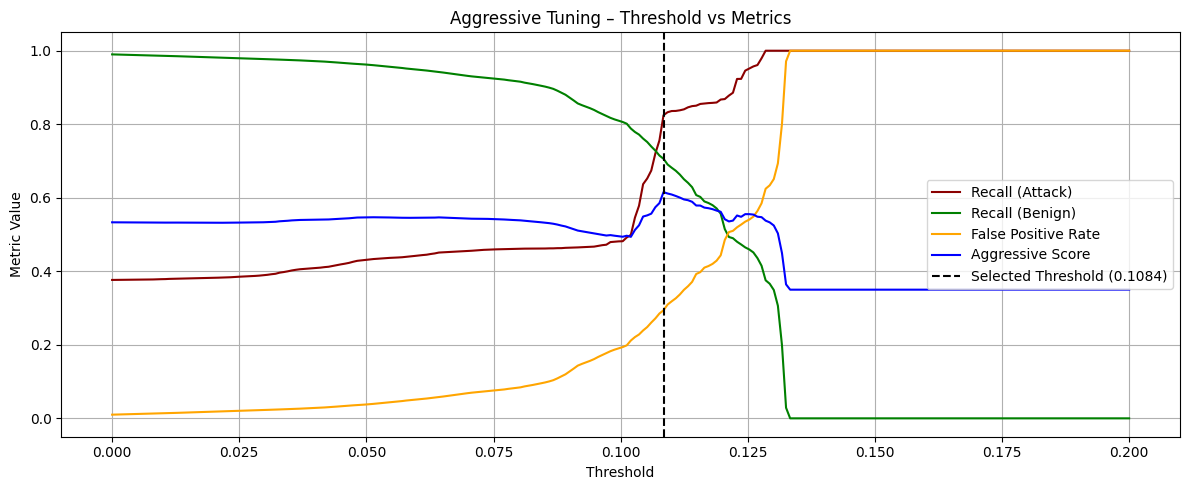

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(aggressive_df["Threshold"], aggressive_df["Recall_Attack"], label="Recall (Attack)", color="darkred")
plt.plot(aggressive_df["Threshold"], aggressive_df["Recall_Benign"], label="Recall (Benign)", color="green")
plt.plot(aggressive_df["Threshold"], aggressive_df["FPR"], label="False Positive Rate", color="orange")
plt.plot(aggressive_df["Threshold"], aggressive_df["Score"], label="Aggressive Score", color="blue")
plt.axvline(x=aggressive_threshold, color="black", linestyle="--", label=f'Selected Threshold ({aggressive_threshold:.4f})')

plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Aggressive Tuning – Threshold vs Metrics")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
summary_csv_path = aggressive_dir / "aggressive_summary.csv"
aggressive_df.to_csv(summary_csv_path, index=False)
print("📄 Aggressive summary saved to:", summary_csv_path)


📄 Aggressive summary saved to: ../../models/3_aggressive_tuned/aggressive_summary.csv
